In [20]:
# install & imports
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib

# Load trained pipeline (preprocessing + XGBoost)
model = joblib.load("models/churn_model_final_v2.joblib")

# Load raw cleaned data (same structure as training input)
df = pd.read_csv("../data/processed/clean_customer_churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_monthly_ratio,services_count,contract_payment_interaction
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.033501,1.0,Month-to-month_Electronic check
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,No,0.597015,3.0,One year_Mailed check
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.037140,3.0,Month-to-month_Mailed check
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1.063830,3.0,One year_Bank transfer (automatic)
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.028289,1.0,Month-to-month_Electronic check


In [21]:
# Split features and target
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"]

from sklearn.model_selection import train_test_split

# Train-test split (same logic as modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target from Yes/No to 0/1 
y_train = y_train.map({"No": 0, "Yes": 1})
y_test  = y_test.map({"No": 0, "Yes": 1})

In [22]:
# fit pipeline
model.fit(X_train, y_train)

# Extract preprocessing step
preprocessor = model.named_steps["preprocessing"]

# Transform raw features
X_test_transformed = preprocessor.transform(X_test)

# Extract trained XGBoost model
xgb_model = model.named_steps["classifier"]

In [23]:
# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

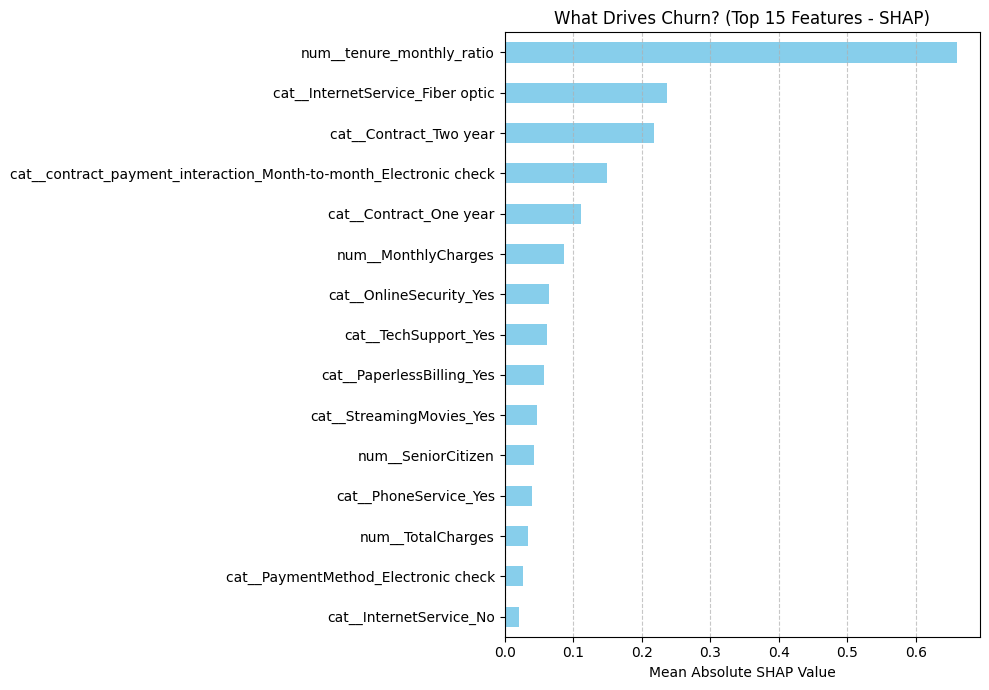

In [24]:
# Global Feature Importance (SHAP)

# This section explains which features have the strongest overall impact on churn predictions.

# Extract feature names and compute mean absolute SHAP values
feature_names = preprocessor.get_feature_names_out()
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create a Series for easy plotting
shap_importance = (
    pd.Series(mean_abs_shap, index=feature_names)
    .sort_values(ascending=False)
)

# Plot the top 15 features
plt.figure(figsize=(10, 7))
shap_importance.head(15).plot(
    kind='barh',
    color='skyblue'
)
plt.gca().invert_yaxis()
plt.title('What Drives Churn? (Top 15 Features - SHAP)')
plt.xlabel('Mean Absolute SHAP Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Features such as contract type, tenure, and internet service have the highest average impact
# on churn. Higher values of these features are associated with increased churn risk,
# while other features have a smaller or neutral effect.

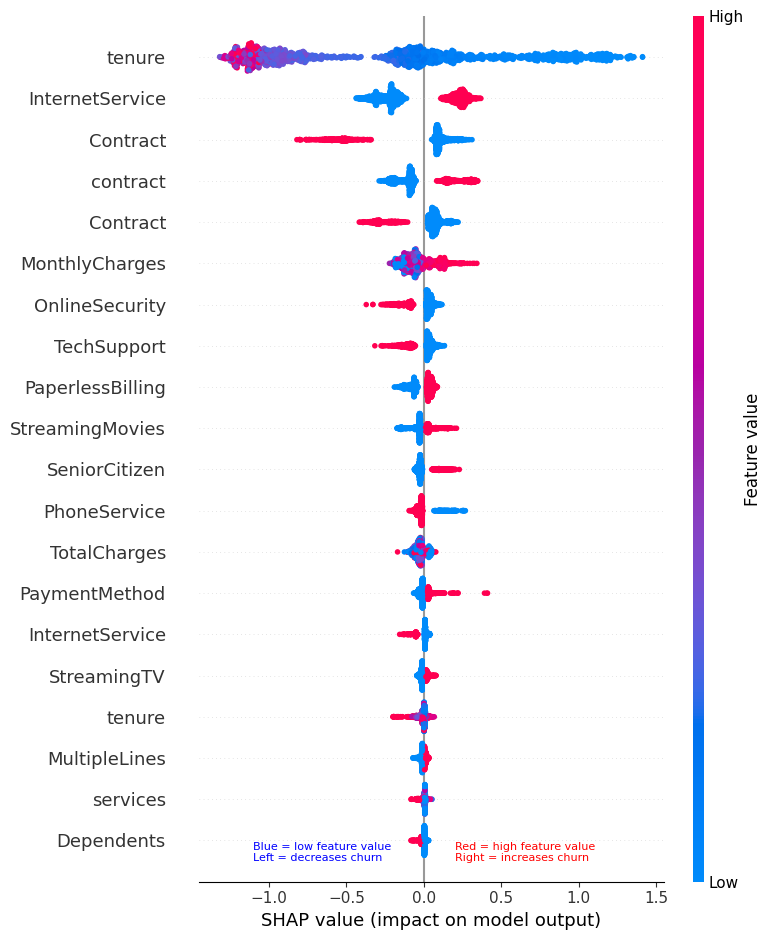

In [26]:
# The SHAP beeswarn summary plot provides a global view of Feature Importance and direction of Impact on churn prediction.

# Map transformed features back to original columns for cleaner SHAP plots
# Handles OneHotEncoded features by keeping only the original column name
original_feature_map = [
    col.split('_')[0] if hasattr(transformer, 'get_feature_names_out') else col
    for name, transformer, cols in preprocessor.transformers_
    for col in (transformer.get_feature_names_out(cols) if hasattr(transformer, 'get_feature_names_out') else cols)
]
plt.text(-1.1, -0.5, "Blue = low feature value\nLeft = decreases churn", 
         fontsize=8, color="blue")
plt.text(0.2, -0.5, "Red = high feature value\nRight = increases churn", 
         fontsize=8, color="red")

# Use original_feature_map as feature names in SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=original_feature_map)

In [27]:
#                        Explaination of the plot

#    Tenure is the strongest driver of churn: customers with low tenure significantly 
# increase churn probability, while long-tenure customers are strongly protected.

#    Contract type plays a key role, with month-to-month contracts associated with 
# higher churn risk compared to long-term contracts. 
#    Multiple entries of categorical features appear due to one-hot encoding.

#    MonthlyCharges shows a clear positive relationship with churn: higher monthly 
# costs increase churn probability.

#    Service-related features such as OnlineSecurity and TechSupport act as protective 
# factors, reducing churn when present.

#    PaymentMethod and InternetService also contribute to churn risk, indicating behavioral
# and service-level patterns beyond pricing alone.

# Overall, churn is primarily driven by a combination of short customer tenure, contract flexibility, and high recurring costs.

Churn probability for customer 1: 26.37%


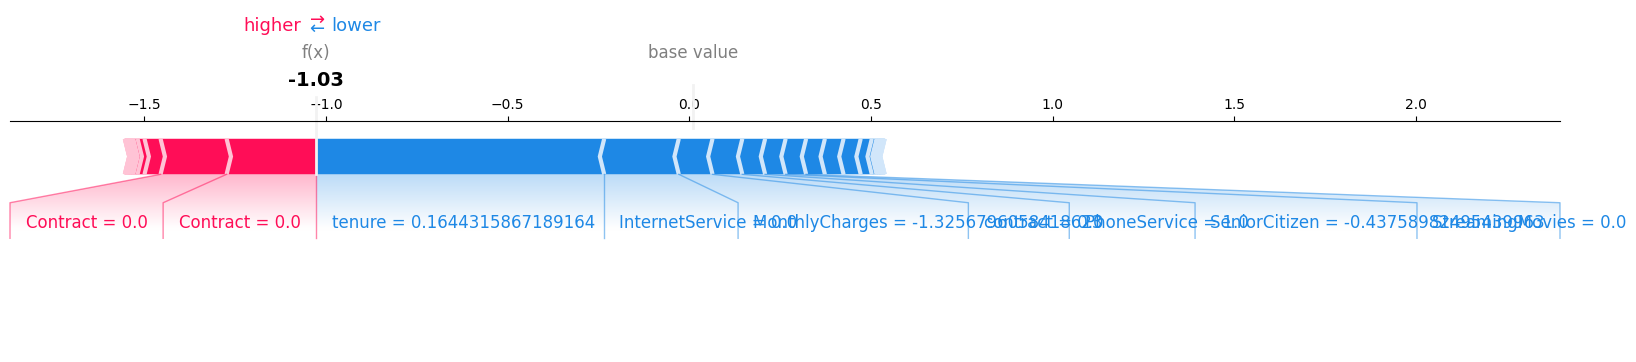

In [28]:
# Compute churn probability of a single customer (choose an index i)

# Use simple row number (0 = first row in X_test)
i = 1  
# Optional: Use original customer index (e.g., 2572)
#i = X_test.index.get_loc(1971)  # convert original index to numpy position

# Extract the transformed row
x_row_transformed = X_test_transformed[i].reshape(1, -1)  # keep 2D

# compute f(x) = expected_value + sum of SHAP values
f_x = explainer.expected_value + shap_values[i].sum()

# convert log-odds to probability
p_churn = 1 / (1 + np.exp(-f_x))
print(f"Churn probability for customer {i}: {p_churn*100:.2f}%")

# Make a force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    x_row_transformed,   # use transformed features
    feature_names=original_feature_map,  # mapped to original features
    matplotlib=True
)


In [29]:
# Compute churn probabilities for all customers
y_probs = model.predict_proba(X_test)[:, 1]  # probability of churn = class 1

# define threshold for high-risk churn
threshold = 0.5  # default

# Identify high-risk customers
high_risk_idx = y_probs >= threshold  # boolean mask
high_risk_customers = X_test[high_risk_idx].copy()
high_risk_customers["Churn_Probability"] = y_probs[high_risk_idx]

# sort by probability descending
high_risk_customers = high_risk_customers.sort_values(by="Churn_Probability", ascending=False)

# Check top high-risk customers
high_risk_customers.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_monthly_ratio,services_count,contract_payment_interaction,Churn_Probability
2572,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,94.60,94.60,0.010571,3.0,Month-to-month_Electronic check,0.884412
1971,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,93.55,93.55,0.010689,3.0,Month-to-month_Electronic check,0.882643
1595,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,88.80,88.80,0.011261,3.0,Month-to-month_Electronic check,0.878171
5132,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,89.25,89.25,0.011204,3.0,Month-to-month_Electronic check,0.876385
842,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,89.90,89.90,0.011123,3.0,Month-to-month_Electronic check,0.876385


Churn Probability of customer 2572 = 0.884


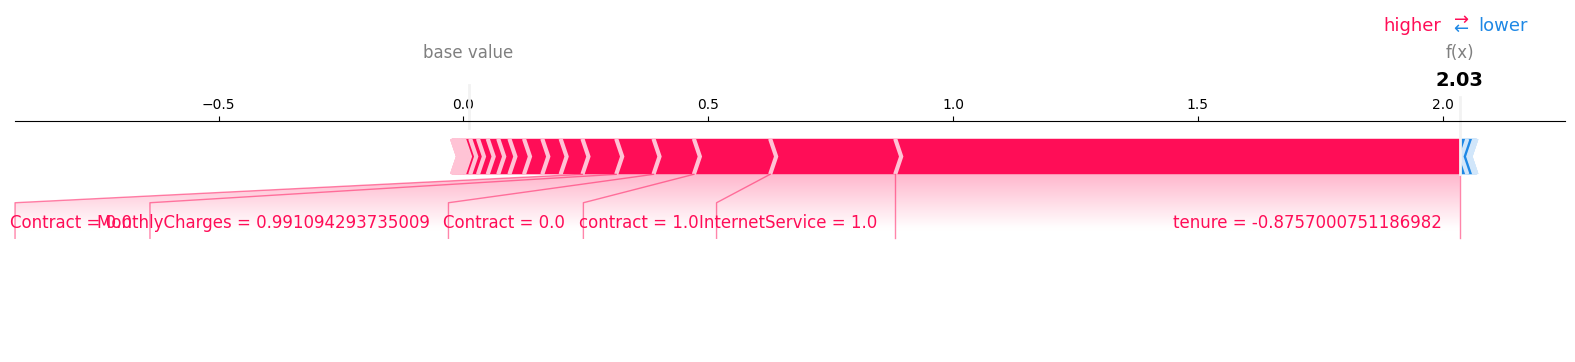

Churn Probability of customer 1971 = 0.883


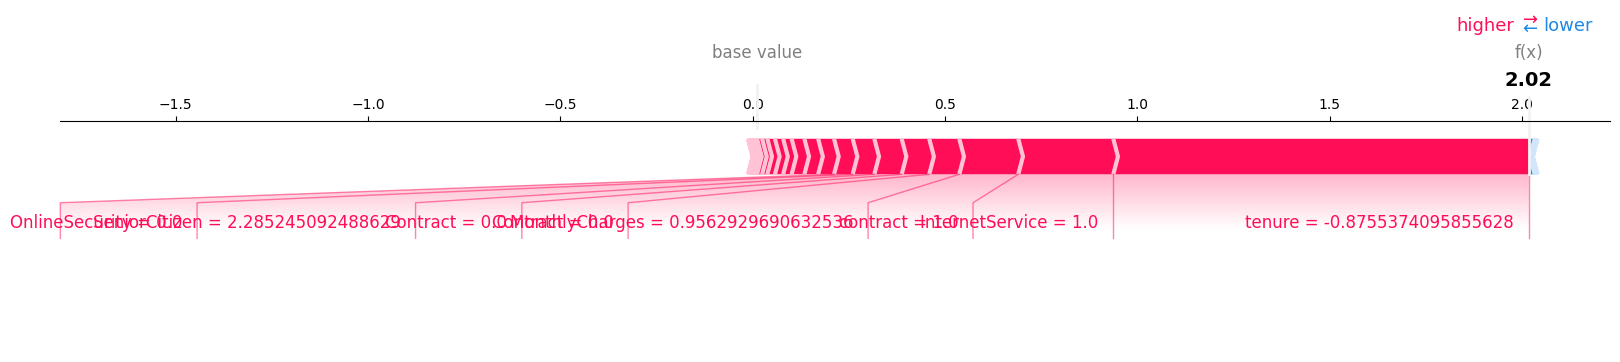

Churn Probability of customer 1595 = 0.878


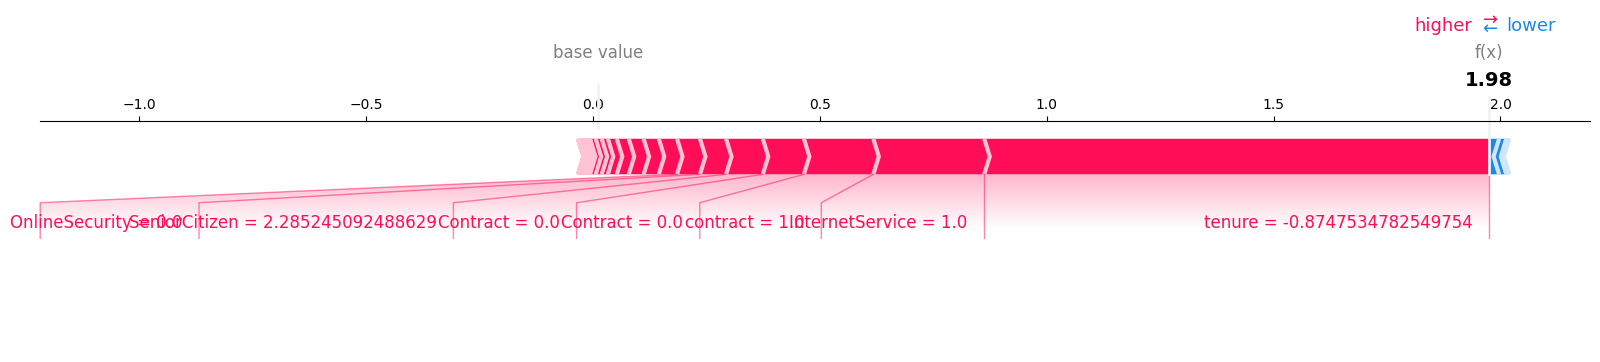

Churn Probability of customer 5132 = 0.876


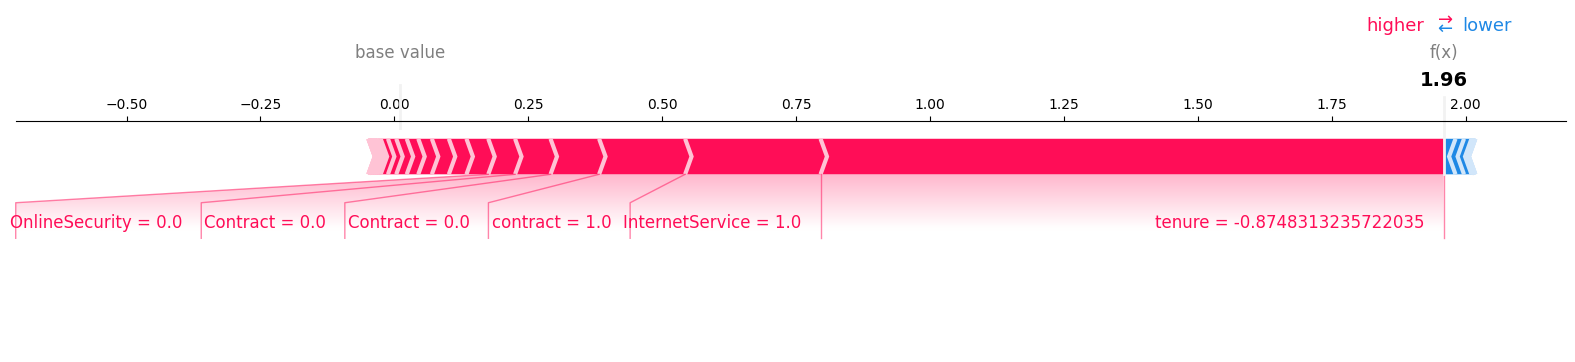

Churn Probability of customer 842 = 0.876


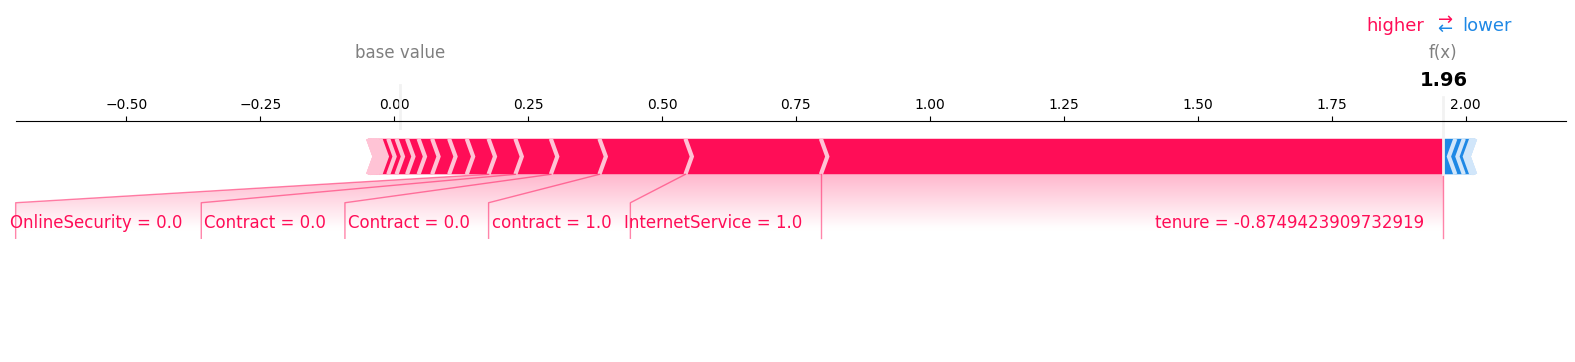

In [30]:
# visualize top 5 high-risk customers

top_n = 5  # number of top customers to explain

for j in range(top_n):
    original_idx = high_risk_customers.index[j]     # e.g., 2572
    pos = X_test.index.get_loc(original_idx)       # position in X_test_transformed/shap_values
    
    print(f"Churn Probability of customer {original_idx} = {high_risk_customers['Churn_Probability'].iloc[j]:.3f}")
    
    # Force plot: matplotlib backend, no plt.show()
    shap.force_plot(
        explainer.expected_value,
        shap_values[pos],
        X_test_transformed[pos],
        feature_names=original_feature_map,
        matplotlib=True
    )

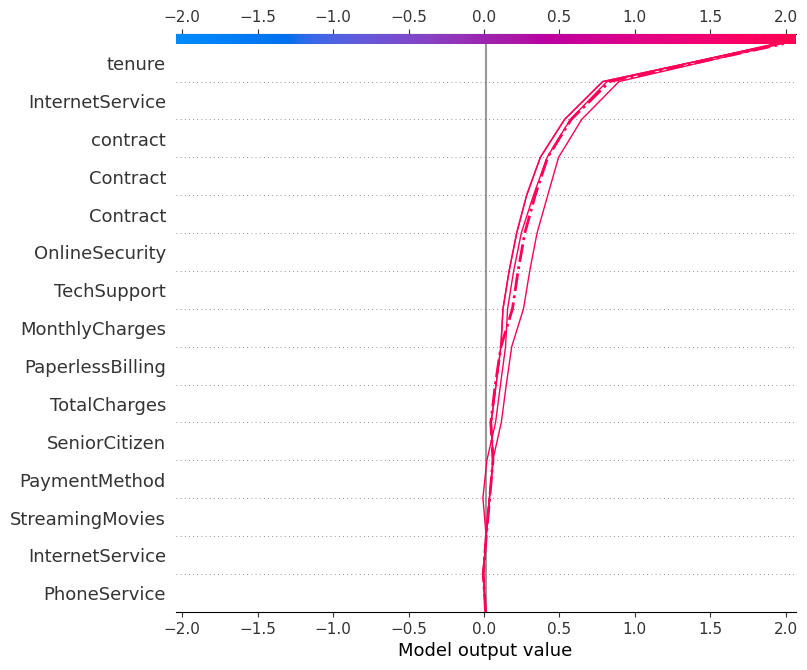

In [31]:
# top N original indices
top_original_idx = high_risk_customers.index[:top_n]

# convert to positions in X_test_transformed / shap_values
top_positions = [X_test.index.get_loc(idx) for idx in top_original_idx]

# extract top customers in numpy arrays
X_top = X_test_transformed[top_positions]
shap_top = shap_values[top_positions]

# Select top 15 features by mean |SHAP value|
mean_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_shap)[-15:]  # indices of top 15 features

plt.figure(figsize=(18, 10))
shap.decision_plot(
    explainer.expected_value,
    shap_top[:, top_features_idx],
    X_top[:, top_features_idx],
    feature_names=np.array(original_feature_map)[top_features_idx],
    highlight=0
)
plt.show()


Customer 2572: Churn Probability = 88.44%


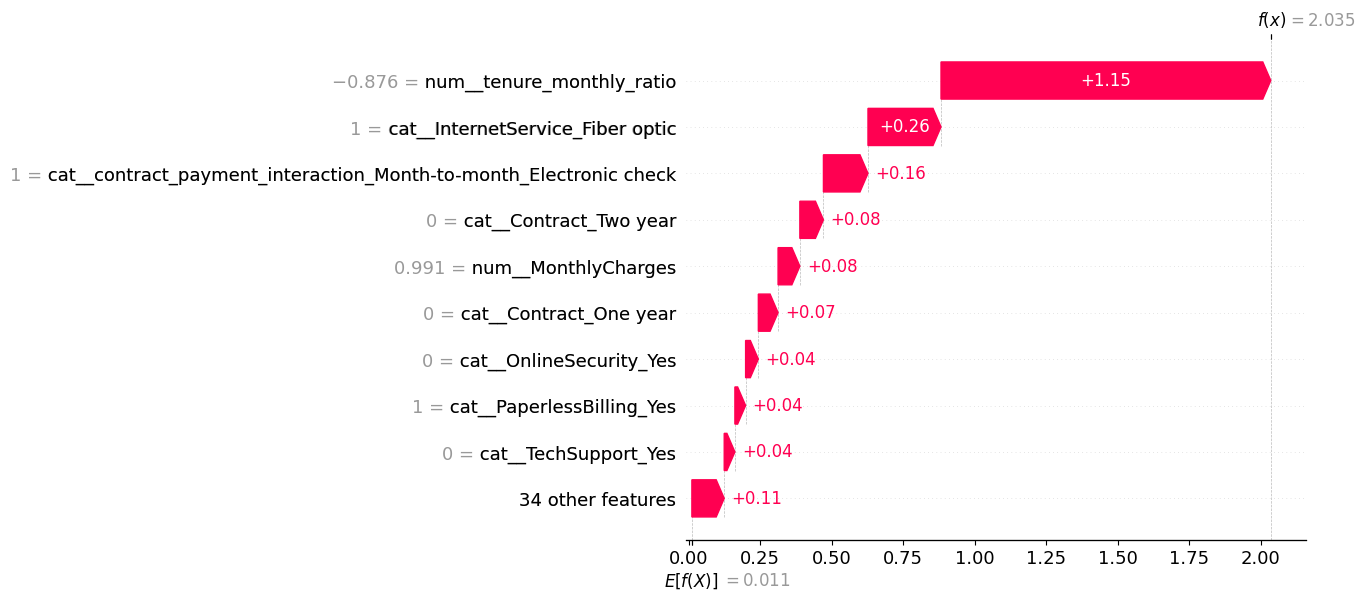


Customer 1971: Churn Probability = 88.26%


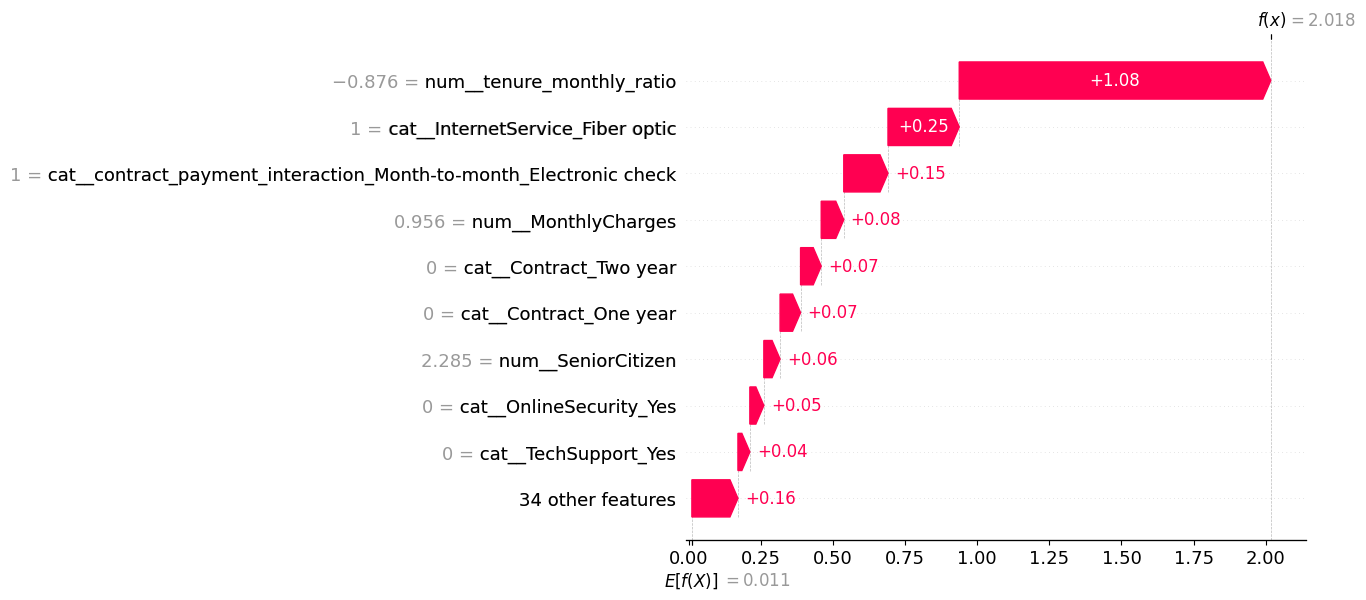


Customer 1595: Churn Probability = 87.82%


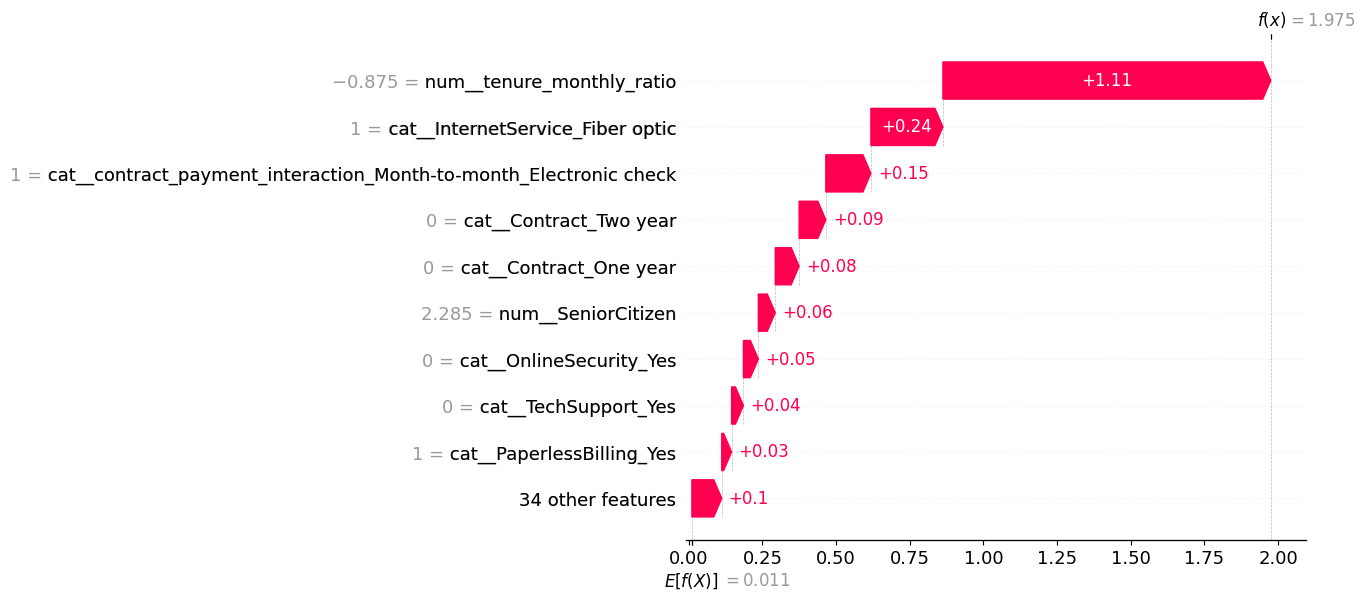


Customer 842: Churn Probability = 87.64%


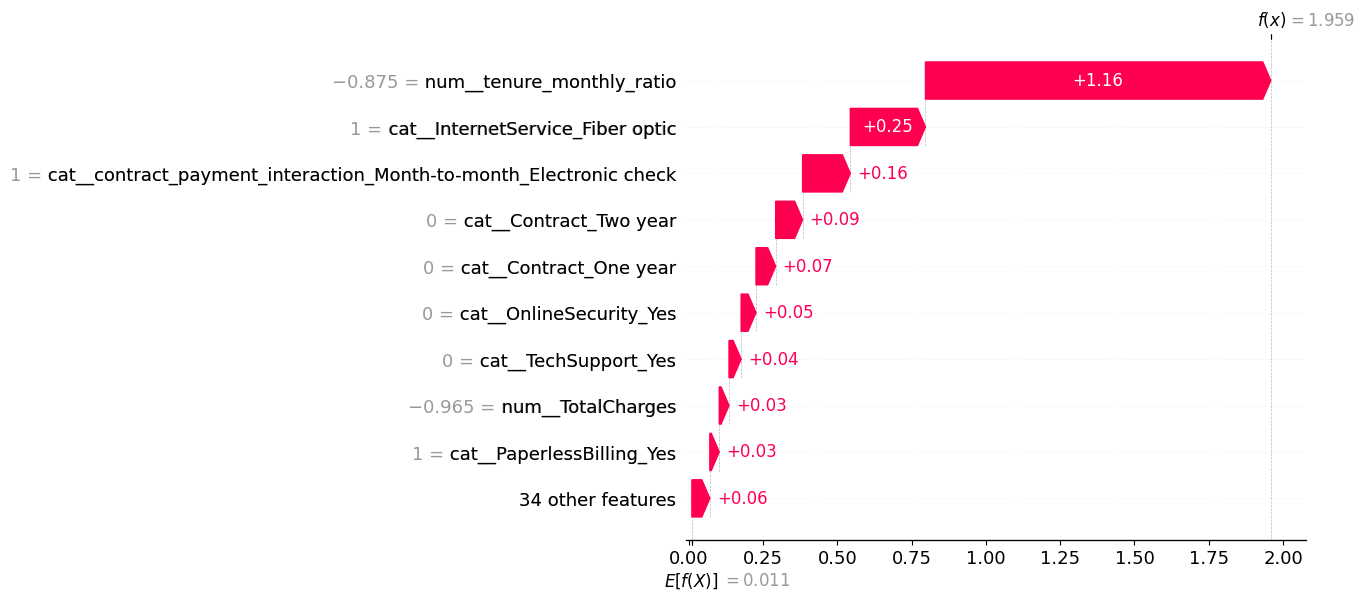


Customer 2392: Churn Probability = 87.64%


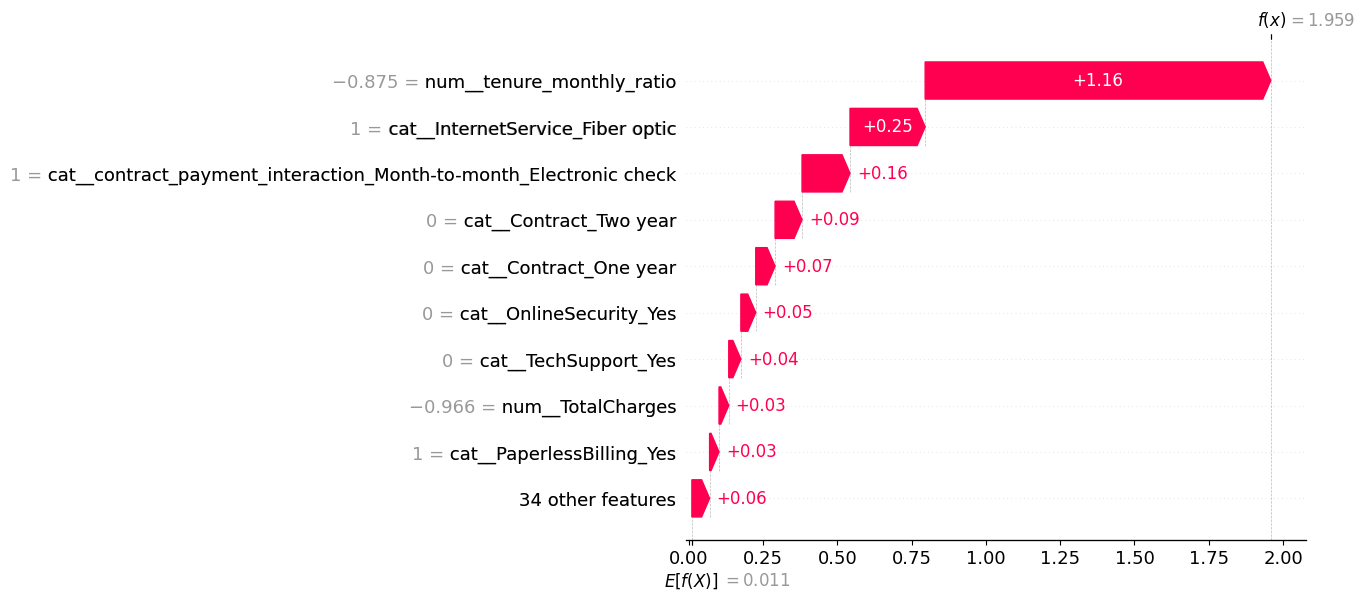

In [32]:
# Customer-Level Explainability

# This section explains individual churn predictions for high-risk customers.
# Each plot shows how different features contribute to the final churn probability.

# Compute churn probabilities for test set
f_x_test = explainer.expected_value + shap_values.sum(axis=1)
p_churn_test = 1 / (1 + np.exp(-f_x_test))  # probability in 0-1

# Add probabilities to test DataFrame
test_results = X_test.copy()
test_results["Churn_Probability"] = p_churn_test


# Waterfall plots for top N high-risk customers

top_customers_idx = test_results["Churn_Probability"].sort_values(ascending=False).head(top_n).index

for original_idx in top_customers_idx:
    pos = X_test.index.get_loc(original_idx)  # convert original index -> numpy position
    p_churn = test_results.loc[original_idx, "Churn_Probability"] * 100
    
    print(f"\nCustomer {original_idx}: Churn Probability = {p_churn:.2f}%")
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[pos],
        base_values=explainer.expected_value,
        data=X_test_transformed[pos],
        feature_names=preprocessor.get_feature_names_out()
    ))



Number of customers per risk bucket:
Risk_Bucket
Low Risk       545
Medium Risk    585
High Risk      277
dtype: int64


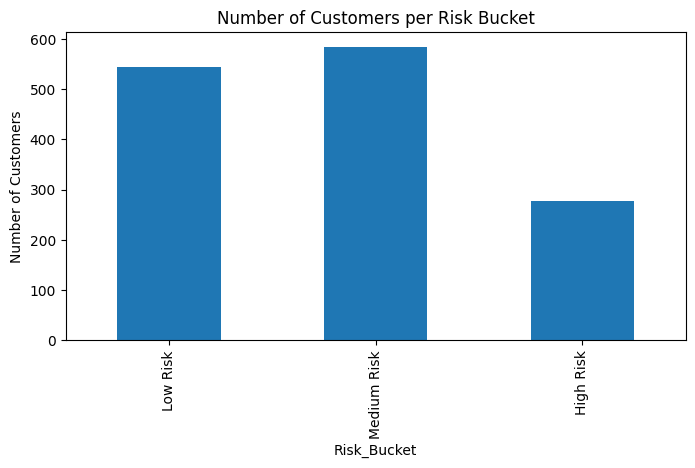

In [33]:
# Risk Segmentation

# Customers are segmented into Low, Medium, and High churn risk groups based on predicted
# probabilities. This enables prioritization of retention efforts.


# Parameters
risk_buckets = {
    "Low Risk": (0, 0.3),
    "Medium Risk": (0.3, 0.7),
    "High Risk": (0.7, 1.0)
}

# Risk Buckets for reporting
bucket_labels = []
for prob in test_results["Churn_Probability"]:
    for bucket, (low, high) in risk_buckets.items():
        if low <= prob < high:
            bucket_labels.append(bucket)
            break

test_results["Risk_Bucket"] = bucket_labels

# Summary table
risk_summary = test_results.groupby("Risk_Bucket").size().reindex(risk_buckets.keys())
print("\nNumber of customers per risk bucket:")
print(risk_summary)

# Plot Risk Buckets
risk_summary.plot(kind='bar', figsize=(8,4), title="Number of Customers per Risk Bucket")
plt.ylabel("Number of Customers")
plt.show()

In [34]:
# High-risk customers represent a smaller but critical segment that should be targeted
# with immediate retention actions.

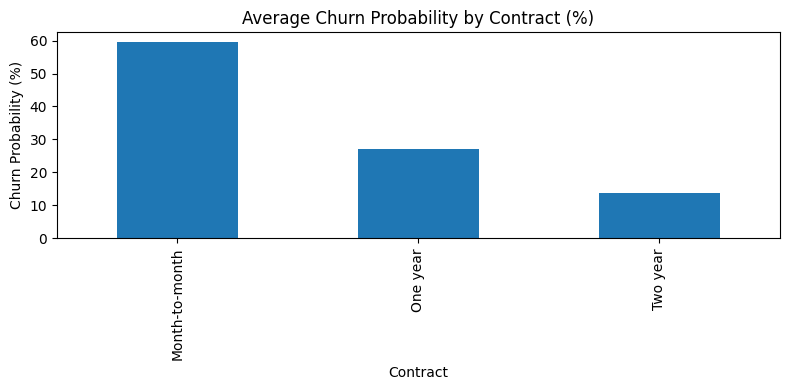

In [35]:
# Cohort Analysis: by a categorical feature (example: 'ContractType')
cohort_feature = "Contract"

if cohort_feature in test_results.columns:
    cohort_summary = (
        test_results
        .groupby(cohort_feature)["Churn_Probability"]
        .mean()
        .sort_values(ascending=False) * 100
    )

    cohort_summary.plot(
        kind="bar",
        figsize=(8, 4),
        title=f"Average Churn Probability by {cohort_feature} (%)"
    )
    plt.ylabel("Churn Probability (%)")
    plt.tight_layout()
    plt.show()

In [36]:
# Customers with month-to-month contracts show significantly higher churn probability,
# suggesting that contract duration plays a key role in retention.

In [37]:
## Business Recommendations

# - Offer retention incentives to high-risk customers.
# - Encourage long-term contracts for customers with month-to-month plans.
# - Monitor key churn drivers such as tenure and monthly charges.
# - Use customer-level explanations to personalize retention strategies.
